In [3]:
import os
import pandas as pd
import operator
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import jinja2
%matplotlib inline

In [4]:
current_directory = Path.cwd()
parent_dir = current_directory.parent

In [5]:
PCS_file_path = f'{parent_dir}/outputs/data/numerical/Patient Characteristics Survey (Years 2013 - 2022) (numerical).csv'
PCS_df = pd.read_csv(PCS_file_path)

### Part 1: Data Understanding and Preparation

In [6]:
PCS_df['Medicaid'] = ((PCS_df['Medicaid Insurance'] == 1) | 
                      (PCS_df['Medicaid Managed Insurance'] == 1) |
                      (PCS_df['Medicaid and Medicare Insurance'] == 1)).astype(float)


In [7]:
survey_years = PCS_df['Survey Year'].unique()

In [ ]:
class SummaryStats:
    def __init__(self, df, variable_of_interest, variable_of_interest_value, percentages=False):
        for year in df['Survey Year'].unique():
            year_data = df[df['Survey Year'] == year]
            count = (year_data[variable_of_interest] == variable_of_interest_value).sum()
            total = len(year_data)
            if percentages:
                print(f'  •  {year}: {count:,} ({count/total:.2%})')
            else:
                print(f'  •  {year}: {count:,}')

In [46]:
print('Number of respondents to each Patient Characteristics Survey:')

for year in survey_years:
    total_number_of_respondents = len(PCS_df['Survey Year'].where(PCS_df['Survey Year']==year).dropna())
    print(f'  •  Number of Respondents in {year}: {total_number_of_respondents:,}')

Number of respondents to each Patient Characteristics Survey:
  •  Number of Respondents in 2013: 180,168
  •  Number of Respondents in 2015: 168,044
  •  Number of Respondents in 2017: 162,065
  •  Number of Respondents in 2019: 120,965
  •  Number of Respondents in 2022: 128,727


In [48]:
print(f'Respondents to the Patient Characteristics Survey with SMI:')

stats = SummaryStats(PCS_df, 'Serious Mental Illness', 1, percentages='yes')

Respondents to the Patient Characteristics Survey with SMI:
  •  2013: 146,711 (81.43%)
  •  2015: 135,492 (80.63%)
  •  2017: 149,632 (92.33%)
  •  2019: 114,287 (94.48%)
  •  2022: 121,909 (94.70%)


In [49]:
print(f'Respondents to the Patient Characteristics Survey enrolled in Medicaid:')

stats = SummaryStats(PCS_df, 'Medicaid', 1, percentages='yes')

Respondents to the Patient Characteristics Survey enrolled in Medicaid:
  •  2013: 132,257 (73.41%)
  •  2015: 124,416 (74.04%)
  •  2017: 119,600 (73.80%)
  •  2019: 88,399 (73.08%)
  •  2022: 96,342 (74.84%)


In [50]:
print(f'Respondents to the Patient Characteristics Survey with SSI Cash Assistance:')

stats = SummaryStats(PCS_df, 'SSI Cash Assistance', 1, percentages='yes')

Respondents to the Patient Characteristics Survey with SSI Cash Assistance:
  •  2013: 68,059 (37.78%)
  •  2015: 56,895 (33.86%)
  •  2017: 54,437 (33.59%)
  •  2019: 36,353 (30.05%)
  •  2022: 35,350 (27.46%)


In [13]:
def summarize_pcs(data, index, filter_conditions_dict, focus_column):
    """
    Summarize PCS data by creating counts and shares for different filter conditions.
    
    Parameters:
        data: DataFrame to analyze
        index: Column to group by (e.g., 'Program Category')
        filter_conditions_dict: Dict of conditions, e.g., {'Employed': {'Employment Status - Employed': 1.0}}
        focus_column: Column to sum (e.g., 'Serious Mental Illness')
    
    Returns:
        DataFrame with totals and shares for each condition
    """
    results = []
    
    # Calculate totals for each filter condition
    for key, conditions in filter_conditions_dict.items():
        # Create filter mask
        mask = True
        for col, val in conditions.items():
            mask &= (data[col] == val)
        
        # Group and sum
        summary = data[mask].groupby(index)[focus_column].sum().round(0).astype(int)
        results.append(summary.rename(f'Total_{key}'))
    
    # Combine all results
    result_df = pd.concat(results, axis=1)
    
    # Add row totals
    result_df['Total'] = result_df.sum(axis=1)
    
    # Calculate shares based on row totals
    for key in filter_conditions_dict.keys():
        result_df[f'Share_{key}'] = (result_df[f'Total_{key}'] / result_df['Total']).round(4)
    
    return result_df

In [ ]:
PCS_SMI_emp_statuses = {}

for year in survey_years:
    # Filter the big dataframe by year
    year_data = PCS_df[PCS_df['Survey Year'] == year]
    
    filter_conditions = {'Employed': {'Serious Mental Illness': 1.0, 'Employment Status': 0.0, 'Age Group': 0.0}, 
                         'Unemployed': {'Serious Mental Illness': 1.0, 'Employment Status': 3.0, 'Age Group': 0.0}}
    
    result = summarize_pcs(
        data=year_data,
        index='Program Category',
        filter_conditions_dict=filter_conditions,
        focus_column='Serious Mental Illness'
    )
    
    # Rename columns
    result = result.rename(columns={
        'Total_Employed': 'Employed Total',
        'Share_Employed': 'Employed Share',
        'Total_Unemployed': 'Unemployed Total',
        'Share_Unemployed': 'Unemployed Share'})
    
    # Replace index values
    result.index = ['Emergency', 'Inpatient', 'Outpatient', 'Residential', 'Support']
    result.index.name = 'Program Category'
    
    # Style and display
    title = f'<span style="font-weight: bold; color: white;">Adult Respondents with Serious Mental Illness by Employment Status and Program Category ({year})</span>'
    styled_result = result.style.set_caption(title)
    
    PCS_SMI_emp_statuses[year] = styled_result
    display(styled_result)
    print('\n')

,Employed Total,Unemployed Total,Total,Employed Share,Unemployed Share
Program Category,,,,,
Emergency,191,233,424,0.450500,0.549500
Inpatient,652,551,1203,0.542000,0.458000
Outpatient,10487,8870,19357,0.541800,0.458200
Residential,2455,2644,5099,0.481500,0.518500
Support,2613,2194,4807,0.543600,0.456400


,Employed Total,Unemployed Total,Total,Employed Share,Unemployed Share
Program Category,,,,,
Emergency,203,256,459,0.442300,0.557700
Inpatient,555,479,1034,0.536800,0.463200
Outpatient,12332,8645,20977,0.587900,0.412100
Residential,2314,2223,4537,0.510000,0.490000
Support,1688,1189,2877,0.586700,0.413300


,Employed Total,Unemployed Total,Total,Employed Share,Unemployed Share
Program Category,,,,,
Emergency,290,275,565,0.513300,0.486700
Inpatient,668,658,1326,0.503800,0.496200
Outpatient,18597,10089,28686,0.648300,0.351700
Residential,2682,2795,5477,0.489700,0.510300
Support,1855,1364,3219,0.576300,0.423700


,Employed Total,Unemployed Total,Total,Employed Share,Unemployed Share
Program Category,,,,,
Emergency,183,244,427,0.428600,0.571400
Inpatient,460,398,858,0.536100,0.463900
Outpatient,15735,8802,24537,0.641300,0.358700
Residential,2002,2382,4384,0.456700,0.543300
Support,1289,1188,2477,0.520400,0.479600


,Employed Total,Unemployed Total,Total,Employed Share,Unemployed Share
Program Category,,,,,
Emergency,168,156,324,0.518500,0.481500
Inpatient,367,308,675,0.543700,0.456300
Outpatient,20552,8465,29017,0.708300,0.291700
Residential,1907,2014,3921,0.486400,0.513600
Support,1322,1186,2508,0.527100,0.472900


In [ ]:
PCS_SMI_emp_statuses = {}

for year in survey_years:
    # Filter the big dataframe by year
    year_data = PCS_df[PCS_df['Survey Year'] == year]
    
    filter_conditions = {'Employed': {'Serious Mental Illness': 1.0, 'Medicaid': 1.0, 'Employment Status': 0.0},
                         'Non-Paid/Volunteer': {'Serious Mental Illness': 1.0, 'Medicaid': 1.0, 'Employment Status': 1.0},
                         'Not in Labor Force': {'Serious Mental Illness': 1.0, 'Medicaid': 1.0, 'Employment Status': 2.0}, 
                         'Unemployed': {'Serious Mental Illness': 1.0, 'Medicaid': 1.0, 'Employment Status': 3.0}}
    
    result = summarize_pcs(data=year_data,
                           index='Program Category',
                           filter_conditions_dict=filter_conditions,
                           focus_column='Serious Mental Illness')
    
    # Rename columns
    result = result.rename(columns={
        'Total_Employed': 'Emp Total',
        'Share_Employed': 'Emp Share',
        'Total_Non-Paid/Volunteer': 'Non-Paid Total',
        'Share_Non-Paid/Volunteer': 'Non-Paid Share',
        'Total_Not in Labor Force': 'NILF Total',
        'Share_Not in Labor Force': 'NILF Share',
        'Total_Unemployed': 'Unemp Total',
        'Share_Unemployed': 'Unemp Share'})
        
    # Replace index values
    result.index = ['Emergency', 'Inpatient', 'Outpatient', 'Residential', 'Support']
    result.index.name = 'Program Category'
    
    # Style and display
    title = f'<span style="font-weight: bold; color: white;">Adult Respondents with Serious Mental Illness by Employment Status and Program Category ({year})</span>'
    styled_result = result.style.set_caption(title)
    
    PCS_SMI_emp_statuses[year] = styled_result
    display(styled_result)
    print('\n')

,Emp Total,Non-Paid Total,NILF Total,Unemp Total,Total,Emp Share,Non-Paid Share,NILF Share,Unemp Share
Program Category,,,,,,,,,
Emergency,60,2,1109,147,1318,0.045500,0.001500,0.841400,0.111500
Inpatient,163,11,4640,328,5142,0.031700,0.002100,0.902400,0.063800
Outpatient,6128,790,53804,7393,68115,0.090000,0.011600,0.789900,0.108500
Residential,2044,464,16884,2502,21894,0.093400,0.021200,0.771200,0.114300
Support,1992,337,11812,1884,16025,0.124300,0.021000,0.737100,0.117600


,Emp Total,Non-Paid Total,NILF Total,Unemp Total,Total,Emp Share,Non-Paid Share,NILF Share,Unemp Share
Program Category,,,,,,,,,
Emergency,73,3,901,180,1157,0.063100,0.002600,0.778700,0.155600
Inpatient,205,13,3938,338,4494,0.045600,0.002900,0.876300,0.075200
Outpatient,7665,675,51024,7415,66779,0.114800,0.010100,0.764100,0.111000
Residential,1952,374,17832,2087,22245,0.087800,0.016800,0.801600,0.093800
Support,1263,159,6250,1009,8681,0.145500,0.018300,0.720000,0.116200


,Emp Total,Non-Paid Total,NILF Total,Unemp Total,Total,Emp Share,Non-Paid Share,NILF Share,Unemp Share
Program Category,,,,,,,,,
Emergency,138,12,1022,212,1384,0.099700,0.008700,0.738400,0.153200
Inpatient,264,18,3899,480,4661,0.056600,0.003900,0.836500,0.103000
Outpatient,10857,817,52122,8676,72472,0.149800,0.011300,0.719200,0.119700
Residential,2329,360,18589,2588,23866,0.097600,0.015100,0.778900,0.108400
Support,1390,210,5162,1134,7896,0.176000,0.026600,0.653700,0.143600


,Emp Total,Non-Paid Total,NILF Total,Unemp Total,Total,Emp Share,Non-Paid Share,NILF Share,Unemp Share
Program Category,,,,,,,,,
Emergency,78,1,537,160,776,0.100500,0.001300,0.692000,0.206200
Inpatient,180,6,2413,281,2880,0.062500,0.002100,0.837800,0.097600
Outpatient,8830,486,34334,7267,50917,0.173400,0.009500,0.674300,0.142700
Residential,1695,278,14224,2224,18421,0.092000,0.015100,0.772200,0.120700
Support,960,156,4135,1038,6289,0.152600,0.024800,0.657500,0.165100


,Emp Total,Non-Paid Total,NILF Total,Unemp Total,Total,Emp Share,Non-Paid Share,NILF Share,Unemp Share
Program Category,,,,,,,,,
Emergency,113,2,567,123,805,0.140400,0.002500,0.704300,0.152800
Inpatient,174,2,2205,227,2608,0.066700,0.000800,0.845500,0.087000
Outpatient,12536,351,38613,7132,58632,0.213800,0.006000,0.658600,0.121600
Residential,1644,158,14821,1881,18504,0.088800,0.008500,0.801000,0.101700
Support,975,78,4553,1033,6639,0.146900,0.011700,0.685800,0.155600


In [ ]:
PCS_SMI_hours_worked_results = {}

for year in survey_years:
    # Filter the big dataframe by year
    year_data = PCS_df[PCS_df['Survey Year'] == year]
    
    index_name = 'Number Of Hours Worked Each Week'

    filter_conditions = {'01-14 HOURS': {'Serious Mental Illness': 1.0, 'Medicaid': 1.0, index_name: 0.0},
                         '15-34 HOURS': {'Serious Mental Illness': 1.0, 'Medicaid': 1.0, index_name: 1.0},
                         '35 HOURS OR MORE': {'Serious Mental Illness': 1.0, 'Medicaid': 1.0, index_name: 2.0}, 
                         'UNEMPLOYED/NOT IN LABOR FORCE': {'Serious Mental Illness': 1.0, 'Medicaid': 1.0, index_name: 3.0}}
    
    result = summarize_pcs(data=year_data,
                           index=index_name,
                           filter_conditions_dict=filter_conditions,
                           focus_column='Serious Mental Illness')
    
    # Replace index values
    result.index = ['01-14 Hours', '15-34 Hours', '35 Hours>=', 'Unemp/NILF']
    result.index.name = index_name

    result = result.drop(columns={'Total_01-14 HOURS', 'Total_15-34 HOURS', 'Total_35 HOURS OR MORE', 'Total_UNEMPLOYED/NOT IN LABOR FORCE',
                                  'Share_01-14 HOURS', 'Share_15-34 HOURS', 'Share_35 HOURS OR MORE', 'Share_UNEMPLOYED/NOT IN LABOR FORCE'})
        
    # Style and display
    title = f'<span style="font-weight: bold; color: white;">Respondents to the Patient Characteristics Survey with Serious Mental Illness Enrolled in Medicaid by Number Of Hours Worked Each Week, {year}</span>'
    styled_result = result.style.set_caption(title).format({'Total': '{:,.0f}'})
    
    PCS_SMI_hours_worked_results[year] = styled_result
    display(styled_result)
    print('\n')

,Total
Number Of Hours Worked Each Week,
01-14 Hours,"3,264"
15-34 Hours,"4,594"
35 Hours>=,"1,574"
Unemp/NILF,"100,503"


,Total
Number Of Hours Worked Each Week,
01-14 Hours,"3,109"
15-34 Hours,"4,788"
35 Hours>=,"2,267"
Unemp/NILF,"90,974"


,Total
Number Of Hours Worked Each Week,
01-14 Hours,"3,391"
15-34 Hours,"5,995"
35 Hours>=,"3,534"
Unemp/NILF,"93,884"


,Total
Number Of Hours Worked Each Week,
01-14 Hours,"2,750"
15-34 Hours,"4,792"
35 Hours>=,"3,222"
Unemp/NILF,"66,613"


,Total
Number Of Hours Worked Each Week,
01-14 Hours,"2,835"
15-34 Hours,"5,775"
35 Hours>=,"5,445"
Unemp/NILF,"71,155"


In [41]:
def plot_correlation_heatmap(df, target_col, cutoff=0.1):
    corr = df.corr()[[target_col]].transpose()
    filtered = corr.loc[:, (corr.abs() > cutoff).any(axis=0)]
    
    plt.figure(figsize=(14, 4))
    sns.heatmap(filtered, annot=True, 
                cmap=sns.diverging_palette(220, 145, as_cmap=True),
                center=0, annot_kws={"size": 8},
                cbar_kws={'label': 'Correlation'})
    plt.title(f'Correlation of {target_col} with Other Variables (|Corr| > {cutoff})', fontsize=10)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(fontsize=8)
    plt.subplots_adjust(left=0.2, right=0.9, top=0.85, bottom=0.4)
    plt.show()

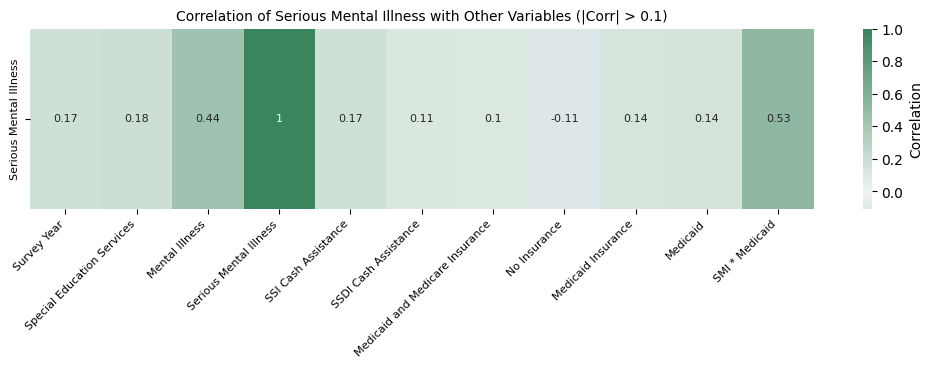

In [42]:
plot_correlation_heatmap(PCS_df, 'Serious Mental Illness', cutoff=0.1)

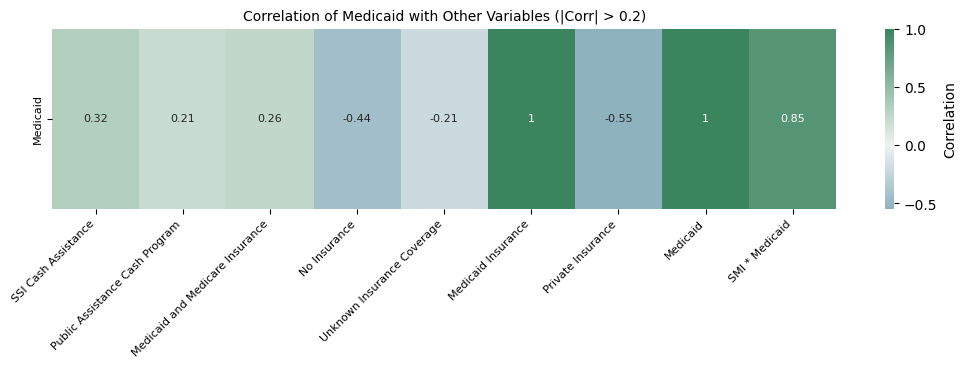

In [43]:
plot_correlation_heatmap(PCS_df, 'Medicaid', cutoff=0.2)

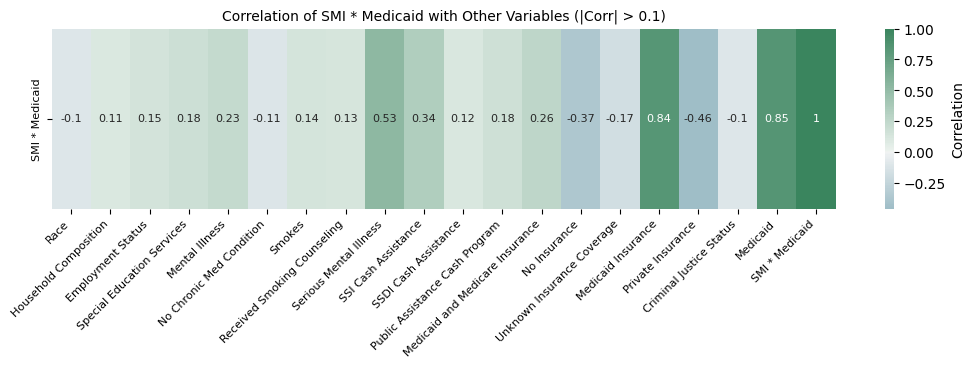

In [44]:
PCS_df['SMI * Medicaid'] = PCS_df['Serious Mental Illness'] * PCS_df['Medicaid']
plot_correlation_heatmap(PCS_df, 'SMI * Medicaid', cutoff=0.1)